### Different ways to build Keras models
There are three APIs for building models in Keras (see figure 7.1):
- The Sequential model, the most approachable API—it’s basically a Python list. As such, it’s limited to simple stacks of layers.
- The Functional API, which focuses on graph-like model architectures. It represents a nice mid-point between usability and flexibility, and as such, it’s the most commonly used model-building API.
- Model subclassing, a low-level option where you write everything yourself from scratch. This is ideal if you want full control over every little thing. However, you won’t get access to many built-in Keras features, and you will be more at risk of making mistakes.

![](./images/7.1.png)

#### The Sequential model
The simplest way to build a Keras model is to use the Sequential model, which you already know about.

##### The Sequential class

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax")
])

Note that it’s possible to build the same model incrementally via the **add()** method, which is similar to the append() method of a Python list.

In [2]:
model = keras.Sequential()
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

You saw in chapter 4 that layers only get built (which is to say, create their weights) when they are called for the first time. That’s because the shape of the layers' weights depends on the shape of their input: until the input shape is known, they can’t be created. <br>
As such, the preceding Sequential model does not have any weights until you actually call it on some data, or call its **build()** method with an input shape.

##### Models that aren’t yet built have no weights

In [3]:
model.weights # At that point, the model isn’t built yet.

ValueError: Weights for model sequential_1 have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.

##### Calling a model for the first time to build it

In [4]:
model.build(input_shape=(None, 3))
model.weights # Now you can retrieve the model’s weights.

[<tf.Variable 'dense_2/kernel:0' shape=(3, 64) dtype=float32, numpy=
 array([[ 0.2724895 , -0.17667829,  0.08634672,  0.03094366,  0.22193986,
          0.00050122, -0.04347321,  0.07433555,  0.24487841,  0.00639936,
         -0.17905024,  0.03159165,  0.09238872,  0.09666827, -0.15783143,
          0.27647716, -0.00293496, -0.00031772,  0.02567136, -0.17179483,
          0.25215816,  0.25621974,  0.00085109, -0.20776993, -0.00292468,
         -0.10972515, -0.03282073, -0.11589427, -0.00592282, -0.258493  ,
         -0.23956133,  0.153824  ,  0.10854927,  0.18189877,  0.25752586,
         -0.03285849,  0.03740495,  0.21729326,  0.09508508,  0.23891473,
         -0.04067102,  0.11505315,  0.08846611, -0.20691112,  0.00076127,
          0.03209037, -0.12196486,  0.079833  , -0.24508905, -0.0773312 ,
          0.28201836,  0.04100344,  0.21173775, -0.07057916,  0.09090418,
         -0.02585095, -0.24240218, -0.01259881,  0.07089615, -0.17753294,
          0.18190491,  0.00064918, -0.15706

Builds the model—now the model will expect samples of shape (3,). **The None in the input shape signals that the batch size could be anything.**

After the model is built, you can display its contents via the **summary()** method, which comes in handy for debugging.

##### The summary() method

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                256       
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


As you can see, this model happens to be named “sequential_1.” You can give names to everything in Keras—every model, every layer.

##### Naming models and layers with the `name` argument

In [6]:
model = keras.Sequential(name="my_example_model")
model.add(layers.Dense(64, activation="relu", name="my_first_layer"))
model.add(layers.Dense(10, activation="softmax", name="my_last_layer"))
model.build(input_shape=(None, 3))
model.summary()

Model: "my_example_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_first_layer (Dense)      (None, 64)                256       
                                                                 
 my_last_layer (Dense)       (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


When building a Sequential model incrementally, it’s useful to be able to print a summary of what the current model looks like after you add each layer. But you can’t print a summary until the model is built! There’s actually a way to have your Sequential built on the fly: just declare the shape of the model’s inputs in advance. You can do this via the **Input** class.

##### Specifying the input shape of your model in advance

In [7]:
model = keras.Sequential()
model.add(keras.Input(shape=(3,))) # Use Input to declare the shape of the inputs. 
# Note that the shape argument must be the shape of each sample, not the shape of one batch.
model.add(layers.Dense(64, activation="relu"))

Now you can use **summary()** to follow how the output shape of your model changes as you add more layers:

In [8]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                256       
                                                                 
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.add(layers.Dense(10, activation="softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                256       
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


This is a pretty common debugging workflow when dealing with layers that transform their inputs in complex ways, such as the convolutional layers you’ll learn about in chapter 8.

#### The Functional API
The **Sequential** model is easy to use, but its applicability is extremely limited: it can only express models with a single input and a single output, applying one layer after the other in a sequential fashion. In practice, it’s pretty common to encounter models with multiple inputs (say, an image and its metadata), multiple outputs (different things you want to predict about the data), or a nonlinear topology. <br>
In such cases, you’d build your model using the **Functional API**. This is what most Keras models you’ll encounter in the wild use. It’s fun and powerful—it feels like playing with LEGO bricks.

##### A SIMPLE EXAMPLE
Let’s start with something simple: the stack of two layers we used in the previous section. <br>
Its Functional API version looks like the following listing.

##### A simple Functional model with two Dense layers

In [10]:
inputs = keras.Input(shape=(3,), name="my_input")
features = layers.Dense(64, activation="relu")(inputs)
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

Let’s go over this step by step.
We started by declaring an **Input** (note that you can also give names to these input objects, like everything else):

In [11]:
inputs = keras.Input(shape=(3,), name="my_input")

This inputs object holds information about the shape and dtype of the data that the model will process:

In [12]:
inputs.shape 

TensorShape([None, 3])

The model will process batches where each sample has shape (3,). The number of samples per batch is variable (indicated by the None batch size).

In [13]:
inputs.dtype

tf.float32

These batches will have dtype float32.

We call such an object a **symbolic tensor**. It doesn’t contain any actual data, but it encodes the specifications of the actual tensors of data that the model will see when you use it. It stands for future tensors of data. <br>
Next, we created a layer and called it on the input:

In [14]:
features = layers.Dense(64, activation="relu")(inputs)

All Keras layers can be called both on real tensors of data and on these symbolic tensors. <br>
In the latter case, they return a new symbolic tensor, with updated shape and dtype information:

In [15]:
features.shape

TensorShape([None, 64])

After obtaining the final outputs, we instantiated the model by specifying its inputs and outputs in the Model constructor:

In [16]:
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

Here’s the summary of our model:

In [17]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_input (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_8 (Dense)             (None, 64)                256       
                                                                 
 dense_9 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


##### MULTI-INPUT, MULTI-OUTPUT MODELS
Unlike this toy model, most deep learning models don’t look like lists—they look like graphs. They may, for instance, have multiple inputs or multiple outputs. It’s for this kind of model that the **Functional API** really shines. <br>
Let’s say you’re building a system to rank customer support tickets by priority and route them to the appropriate department. Your model has three inputs:
- The title of the ticket (text input)
- The text body of the ticket (text input)
- Any tags added by the user (categorical input, assumed here to be one-hot encoded)

We can encode the text inputs as arrays of ones and zeros of size vocabulary_size (see chapter 11 for detailed information about text encoding techniques). <br>
Your model also has two outputs:
- The priority score of the ticket, a scalar between 0 and 1 (**sigmoid** output)
- The department that should handle the ticket (a **softmax** over the set of departments)

You can build this model in a few lines with the Functional API.


##### A multi-input, multi-output Functional model

In [18]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

# Define model inputs
title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

features = layers.Concatenate()([title, text_body, tags]) # Combine input features into a single tensor, features, by concatenating them.
features = layers.Dense(64, activation="relu")(features) # Apply an intermediate layer to recombine input features into richer representations.

# Define model outputs
priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(num_departments, activation="softmax", name="department")(features)

# Create the model by specifying its inputs and outputs.
model  = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

The Functional API is a simple, LEGO-like, yet very flexible way to define arbitrary graphs of layers like these.

##### TRAINING A MULTI-INPUT, MULTI-OUTPUT MODEL
You can train your model in much the same way as you would train a Sequential model, by calling **fit()** with lists of input and output data. These lists of data should be in the same order as the inputs you passed to the **Model** constructor.

##### Training a model by providing lists of input and target arrays

In [19]:
import numpy as np

num_samples = 1280

# Dummy input data
title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

# Dummy target(output) data
priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])

model.fit([title_data, text_body_data, tags_data],
          [priority_data, department_data],
          epochs=1)

model.evaluate([title_data, text_body_data, tags_data],
                [priority_data, department_data])

priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

40/40 [==============================] - 0s 5ms/step - loss: 33.7820 - priority_loss: 0.3264 - department_loss: 33.4556 - priority_mean_absolute_error: 0.4906 - department_accuracy: 0.2477


If you don’t want to rely on input order (for instance, because you have many inputs or outputs), you can also leverage the names you gave to the Input objects and the output layers, and pass data via dictionaries.

##### Training a model by providing dicts of input and target arrays

In [20]:
model.compile(optimizer="rmsprop",
              loss={"priority": "mean_squared_error", "department": "categorical_crossentropy"},
              metrics={"priority": ["mean_absolute_error"], "department": ["accuracy"]})

model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data},
          {"priority": priority_data, "department": department_data},
          epochs=1)

model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data},
          {"priority": priority_data, "department": department_data})

priority_preds, department_preds = model.predict({"title": title_data, "text_body": text_body_data, "tags": tags_data})

40/40 [==============================] - 0s 5ms/step - loss: 37.4851 - priority_loss: 0.3264 - department_loss: 37.1588 - priority_mean_absolute_error: 0.4906 - department_accuracy: 0.3242


##### THE POWER OF THE FUNCTIONAL API: ACCESS TO LAYER CONNECTIVITY
- A Functional model is an explicit graph data structure. 
- This makes it possible to inspect how layers are connected and reuse previous graph nodes (which are layer outputs) as part of new models. 
- It also nicely fits the “mental model” that most researchers use when thinking about a deep neural network: a graph of layers. 
- This enables two important use cases: **model visualization** and **feature extraction**.

Let’s visualize the connectivity of the model we just defined (the topology of the model). You can plot a Functional model as a graph with the **plot_model()** utility (see figure 7.2).

In [21]:
keras.utils.plot_model(model, "ticket_classifier.png")

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


![](./images/7.2.png)

You can add to this plot the input and output shapes of each layer in the model, which can be helpful during debugging (see figure 7.3).

In [22]:
keras.utils.plot_model(model, "ticket_classifier_with_shape_info.png", show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


![](./images/7.3.png)

The “None” in the tensor shapes represents the batch size: this model allows batches of any size. <br>
Access to layer connectivity also means that you can inspect and reuse individual nodes (layer calls) in the graph. The **model.layers** model property provides the list of layers that make up the model, and for each layer you can query **layer.input** and **layer.output**.

##### Retrieving the inputs or outputs of a layer in a Functional model

In [23]:
model.layers

In [24]:
model.layers[3].input

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

In [25]:
model.layers[3].output

<KerasTensor: shape=(None, 20100) dtype=float32 (created by layer 'concatenate')>

This enables you to do **feature extraction**, creating models that reuse intermediate features from another model. <br>
Let’s say you want to add another output to the previous model—you want to estimate how long a given issue ticket will take to resolve, a kind of difficulty rating. You could do this via a classification layer over three categories: “quick,” “medium,” and “difficult.” You don’t need to recreate and retrain a model from scratch. You can start from the intermediate features of your previous model, since you have access to them, like this.

In [26]:
features = model.layers[4].output # layer[4] is our intermediate Dense layer.
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)

new_model = keras.Model(
    inputs=[title, text_body, tags],
    outputs=[priority, department, difficulty])

Let’s plot our new model (see figure 7.4):

In [27]:
keras.utils.plot_model(new_model, "updated_ticket_classifier.png", show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


![](./images/7.4.png)

#### Subclassing the Model class
The last model-building pattern you should know about is the most advanced one: **Model** subclassing. You learned in chapter 3 how to subclass the Layer class to create custom layers. Subclassing Model is pretty similar:
- In the **__init__()** method, define the layers the model will use.
- In the **call()** method, define the forward pass of the model, reusing the layers previously created.
- Instantiate your subclass, and call it on data to create its weights.

##### REWRITING OUR PREVIOUS EXAMPLE AS A SUBCLASSED MODEL
Let’s take a look at a simple example: we will reimplement the customer support ticket management model using a **Model** subclass.

##### A simple subclassed model

In [28]:
class CustomerTicketModel(keras.Model):

    def __init__(self, num_departments):
        super().__init__() # Don't forget to call the super() constructor!
        # Define sublayers in the constructor.
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation="relu")
        self.priority_scorer = layers.Dense(1, activation="sigmoid")
        self.department_classifier = layers.Dense(num_departments, activation="softmax")
    
    # Define the forward pass in the call() method.
    def call(self, inputs):
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"]

        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

Once you’ve defined the model, you can instantiate it. Note that it will only create its weights the first time you call it on some data, much like **Layer** subclasses:

In [29]:
model = CustomerTicketModel(num_departments=4)

priority, department = model({"title": title_data, "text_body": text_body_data, "tags": tags_data})

So far, everything looks very similar to **Layer** subclassing, a workflow you encountered in chapter 3. What, then, is the difference between a **Layer** subclass and a **Model** subclass? <br>
It’s simple: a “layer” is a building block you use to create models, and a “model” is the top-level object that you will actually train, export for inference, etc. In short, a **Model** has **fit()**, **evaluate()**, and **predict()** methods. Layers don’t. Other than that, the two classes are virtually identical. (Another difference is that you can **save** a model to a file on disk, which we will cover in a few sections.)

You can compile and train a **Model** subclass just like a **Sequential** or **Functional** model:

In [30]:
# The structure of what you pass as the loss and metrics arguments must match exactly what gets returned by call() method—here, a list of two elements.
model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])

# The structure of the input data must match exactly what is expected by the call() method— here, a dict with keys title, text_body, and tags.
model.fit({"title": title_data,
           "text_body": text_body_data,
           "tags": tags_data},
          [priority_data, department_data], # The structure of the target data must match exactly what is returned by the call() method—here a list of two elements.
          epochs=1)

model.evaluate({"title": title_data,
                "text_body": text_body_data,
                "tags": tags_data},
               [priority_data, department_data])

priority_preds, department_preds = model.predict({"title": title_data,
                                                  "text_body": text_body_data,
                                                  "tags": tags_data})

40/40 [==============================] - 0s 5ms/step - loss: 41.5722 - output_1_loss: 0.3264 - output_2_loss: 41.2458 - output_1_mean_absolute_error: 0.4906 - output_2_accuracy: 0.2477


The **Model** subclassing workflow is the most flexible way to build a model. It enables you to build models that cannot be expressed as directed acyclic graphs of layers—imagine, for instance, a model where the **call()** method uses layers inside a **for** loop, or even calls them recursively. Anything is possible—you’re in charge.

##### BEWARE: WHAT SUBCLASSED MODELS DON’T SUPPORT
This freedom comes at a cost: with subclassed models, you are responsible for more of the model logic, which means your potential error surface is much larger. As a result, you will have more debugging work to do. You are developing a new Python object, not just snapping together LEGO bricks.

Functional and subclassed models are also substantially different in nature. A Functional model is an explicit data structure—a graph of layers, which you can view, inspect, and modify. A subclassed model is a piece of bytecode—a Python class with a **call()** method that contains raw code. This is the source of the subclassing workflow’s flexibility—you can code up whatever functionality you like—but it introduces new limitations.

For instance, because the way layers are connected to each other is hidden inside the body of the **call()** method, you cannot access that information. Calling **summary()** will not display layer connectivity, and you cannot plot the model topology via **plot_model()**. Likewise, if you have a subclassed model, you cannot access the nodes of the graph of layers to do feature extraction because there is simply no graph. Once the model is instantiated, its forward pass becomes a complete black box.

#### Mixing and matching different components
Crucially, choosing one of these patterns—the Sequential model, the Functional API, or Model subclassing—does not lock you out of the others. All models in the Keras API can smoothly interoperate with each other, whether they’re Sequential models, Functional models, or subclassed models written from scratch. They’re all part of the same spectrum of workflows. <br>
For instance, you can use a subclassed layer or model in a Functional model.

##### Creating a Functional model that includes a subclassed model

In [31]:
class Classifier(keras.Model):

    def __init__(self, num_classes=2):
        super().__init__()
        if num_classes == 2:
            num_units = 1
            activation = "sigmoid"
        else:
            num_units = num_classes
            activation = "softmax"
        self.dense = layers.Dense(num_units, activation=activation)
    
    def call(self, inputs):
        return self.dense(inputs)

inputs = keras.Input(shape=(3,))
features = layers.Dense(64, activation="relu")(inputs)
outputs = Classifier(num_classes=10)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

Inversely, you can use a Functional model as part of a subclassed layer or model.

##### Creating a subclassed model that includes a Functional model

In [32]:
inputs = keras.Input(shape=(64,))
outputs = layers.Dense(1, activation="sigmoid")(inputs)
binary_classifier = keras.Model(inputs=inputs, outputs=outputs)

class MyModel(keras.Model):

    def __init__(self, num_classes=2):
        super().__init__()
        self.dense = layers.Dense(64, activation="relu")
        self.classifier = binary_classifier
    
    def call(self, inputs):
        features = self.dense(inputs)
        return self.classifier(features)

model = MyModel()

##### Remember: Use the right tool for the job
You’ve learned about the spectrum of workflows for building Keras models, from the simplest workflow, the Sequential model, to the most advanced one, model subclassing. <br>
When should you use one over the other? Each one has its pros and cons—pick the one most suitable for the job at hand.

In general, the Functional API provides you with a pretty good trade-off between ease of use and flexibility. It also gives you direct access to layer connectivity, which is very powerful for use cases such as model plotting or feature extraction. <br> If you can use the Functional API—that is, if your model can be expressed as a directed acyclic graph of layers—I recommend using it over model subclassing.

Going forward, all examples in this book will use the Functional API, simply because all the models we will work with are expressible as graphs of layers. We will, however, make frequent use of subclassed layers. In general, using Functional models that include subclassed layers provides the best of both worlds: high development flexibility while retaining the advantages of the Functional API.

#### Using built-in training and evaluation loops
The principle of progressive disclosure of complexity—access to a spectrum of workflows that go from dead easy to arbitrarily flexible, one step at a time—also applies to model training. Keras provides you with different workflows for training models. They can be as simple as calling **fit()** on your data, or as advanced as writing a new training algorithm from scratch. <br>
You are already familiar with the **compile()**, **fit()**, **evaluate()**, **predict()** workflow. As a reminder, take a look at the following listing.

##### The standard workflow: compile(), fit(), evaluate(), predict()

In [33]:
from tensorflow.keras.datasets import mnist

# Create a model (we factor this into a separate function so as to reuse it later).
def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Load your data, reserving some for validation.
(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

model = get_mnist_model()

# Compile the model by specifying its optimizer, the loss function to minimize, and the metrics to monitor.
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Use fit() to train the model, optionally providing validation data to monitor performance on unseen data.
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))

# Use evaluate() to compute the loss and metrics on new data.
test_metrics = model.evaluate(test_images, test_labels)
# Use predict() to compute classification probabilities on new data.
predictions = model.predict(test_images)

Epoch 1/3
1563/1563 [==============================] - 9s 5ms/step - loss: 0.2992 - accuracy: 0.9122 - val_loss: 0.1492 - val_accuracy: 0.9572
Epoch 2/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1665 - accuracy: 0.9529 - val_loss: 0.1227 - val_accuracy: 0.9664
Epoch 3/3
313/313 [==============================] - 0s 1ms/step - loss: 0.1195 - accuracy: 0.9699


There are a couple of ways you can customize this simple workflow:
- Provide your own custom metrics.
- Pass **callbacks** to the **fit()** method to schedule actions to be taken at specific points during training.

Let’s take a look at these.

##### Writing your own metrics
Metrics are key to measuring the performance of your model—in particular, to measuring the difference between its performance on the training data and its performance on the test data. Commonly used metrics for classification and regression are already part of the built-in **keras.metrics** module, and most of the time that’s what you will use. But if you’re doing anything out of the ordinary, you will need to be able to write your own metrics. It’s simple!

A Keras metric is a subclass of the **keras.metrics.Metric** class. Like layers, a metric has an internal state stored in TensorFlow variables. Unlike layers, these variables aren’t updated via backpropagation, so you have to write the state-update logic yourself, which happens in the **update_state()** method.

For example, here’s a simple custom metric that measures the root mean squared error (RMSE).

##### Implementing a custom metric by subclassing the Metric class

In [34]:
import tensorflow as tf

class RootMeanSquaredError(keras.metrics.Metric):

    # Define the state variables in the constructor. Like for layers, you have access to the add_weight() method.
    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(name="total_samples", initializer="zeros", dtype="int32")
    
    # Implement the state update logic in update_state(). The y_true argument is the targets (or labels) for one batch, while y_pred represents the corresponding predictions from the model. 
    # You can ignore the sample_weight argument—we won’t use it here.
    def update_state(self, y_true, y_pred, sample_weight=None):
        # To match our MNIST model, we expect categorical predictions and integer labels.
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    # You use the result() method to return the current value of the metric:
    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))
    
    # Meanwhile, you also need to expose a way to reset the metric state without having to reinstantiate it—this enables the same metric objects to be used across different epochs of training or across both training and evaluation. 
    # You do this with the reset_state() method:
    def reset_states(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

Custom metrics can be used just like built-in ones. Let’s test-drive our own metric:

In [35]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", RootMeanSquaredError()])

model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))

test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1555/1563 [============================>.] - ETA: 0s - loss: 0.2971 - accuracy: 0.9123 - rmse: 7.1825

C:\Users\batuh\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:1841: UserWarning: Metric RootMeanSquaredError implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


1563/1563 [==============================] - 9s 5ms/step - loss: 0.2962 - accuracy: 0.9126 - rmse: 7.1826 - val_loss: 0.1428 - val_accuracy: 0.9592 - val_rmse: 7.3539
Epoch 2/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1636 - accuracy: 0.9538 - rmse: 7.3533 - val_loss: 0.1194 - val_accuracy: 0.9678 - val_rmse: 7.4045
Epoch 3/3
313/313 [==============================] - 0s 1ms/step - loss: 0.1037 - accuracy: 0.9715 - rmse: 7.4326


You can now see the **fit()** progress bar displaying the RMSE of your model.

##### Using callbacks
Launching a training run on a large dataset for tens of epochs using **model.fit()** can be a bit like launching a paper airplane: past the initial impulse, you don’t have any control over its trajectory or its landing spot. If you want to avoid bad outcomes (and thus wasted paper airplanes), it’s smarter to use, not a paper plane, but a drone that can sense its environment, send data back to its operator, and automatically make steering decisions based on its current state. The Keras **callbacks** API will help you transform your call to **model.fit()** from a paper airplane into a smart, autonomous drone that can self-introspect and dynamically take action.

A **callback** is an object (a class instance implementing specific methods) that is passed to the model in the call to **fit()** and that is called by the model at various points during training. It has access to all the available data about the state of the model and its performance, and it can take action: interrupt training, save a model, load a different weight set, or otherwise alter the state of the model. <br>
Here are some examples of ways you can use callbacks:
- **Model checkpointing**—Saving the current state of the model at different points during training.
- **Early stopping**—Interrupting training when the validation loss is no longer improving (and of course, saving the best model obtained during training).
- **Dynamically adjusting the value of certain parameters during training**—Such as the learning rate of the optimizer.
- **Logging training and validation metrics during training, or visualizing the representations learned by the model as they’re updated**—The **fit()** progress bar that you’re familiar with is in fact a callback!

The **keras.callbacks** module includes a number of built-in callbacks (this is not an exhaustive list): <br>
keras.callbacks.ModelCheckpoint <br>
keras.callbacks.EarlyStopping <br>
keras.callbacks.LearningRateScheduler <br>
keras.callbacks.ReduceLROnPlateau <br>
keras.callbacks.CSVLogger <br>

Let’s review two of them to give you an idea of how to use them: **EarlyStopping** and **ModelCheckpoint**.

##### THE EARLYSTOPPING AND MODELCHECKPOINT CALLBACKS
When you’re training a model, there are many things you can’t predict from the start. In particular, you can’t tell how many epochs will be needed to get to an optimal validation loss. Our examples so far have adopted the strategy of training for enough epochs that you begin overfitting, using the first run to figure out the proper number of epochs to train for, and then finally launching a new training run from scratch using this optimal number. Of course, this approach is wasteful. A much better way to handle this is to stop training when you measure that the validation loss is no longer improving. This can be achieved using the **EarlyStopping** callback.

The **EarlyStopping** callback interrupts training once a target metric being monitored has stopped improving for a fixed number of epochs. For instance, this callback allows you to interrupt training as soon as you start overfitting, thus avoiding having to retrain your model for a smaller number of epochs. This callback is typically used in combination with **ModelCheckpoint**, which lets you continually save the model during training (and, optionally, save only the current best model so far: the version of the model that achieved the best performance at the end of an epoch).

##### Using the callbacks argument in the fit() method

In [36]:
# Callbacks are passed to the model via the callbacks argument in fit(), which takes a list of callbacks. 
# You can pass any number of callbacks.
callbacks_list = [
    keras.callbacks.EarlyStopping( # Interrupts training when improvement stops
        monitor="val_accuracy", # Monitors the model’s validation accuracy
        patience=2, # Interrupts training when the model has not improved for 2 epochs
    ),
    keras.callbacks.ModelCheckpoint( # Saves the current weights after every epoch
        filepath="checkpoint_path.keras", # Path to the destination model file
        # These two arguments mean you won’t overwrite the model file unless val_loss has improved, which allows you to keep the best model seen during training.
        monitor="val_loss",
        save_best_only=True,
    )
]

model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"]) # You monitor accuracy, so it should be part of the model’s metrics.
# Note that because the callback will monitor validation loss and validation accuracy, you need to pass validation_data to the call to fit().
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=callbacks_list,
          validation_data=(val_images, val_labels))

Epoch 1/10
1563/1563 [==============================] - 9s 5ms/step - loss: 0.2954 - accuracy: 0.9118 - val_loss: 0.1542 - val_accuracy: 0.9570
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1664 - accuracy: 0.9527 - val_loss: 0.1196 - val_accuracy: 0.9654
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1407 - accuracy: 0.9626 - val_loss: 0.1232 - val_accuracy: 0.9701
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1260 - accuracy: 0.9676 - val_loss: 0.1137 - val_accuracy: 0.9746
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1163 - accuracy: 0.9706 - val_loss: 0.1126 - val_accuracy: 0.9737
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1116 - accuracy: 0.9729 - val_loss: 0.1145 - val_accuracy: 0.9749
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1050 - accuracy: 0.9750 - val_loss: 0.1190 - val_accuracy:

Note that you can always save models manually after training as well—just call **model.save('my_checkpoint_path')**. To reload the model you’ve saved, just use
```python
model = keras.models.load_model("checkpoint_path.keras")
```

In [37]:
model = keras.models.load_model("checkpoint_path.keras")

##### Writing your own callbacks
If you need to take a specific action during training that isn’t covered by one of the built-in callbacks, you can write your own callback. Callbacks are implemented by subclassing the **keras.callbacks.Callback** class. You can then implement any number of the following transparently named methods, which are called at various points during training:
- on_epoch_begin(epoch, logs) # Called at the start of every epoch
- on_epoch_end(epoch, logs) # Called at the end of every epoch
- on_batch_begin(batch, logs) # Called right before processing each batch
- on_batch_end(batch, logs) # Called right after processing each batch
- on_train_begin(logs) # Called at the start of training
- on_train_end(logs) # Called at the end of training

These methods are all called with a **logs** argument, which is a dictionary containing information about the previous batch, epoch, or training run—training and validation metrics, and so on. The **on_epoch_*** and **on_batch_*** methods also take the epoch or batch index as their first argument (an integer).

Here’s a simple example that saves a list of per-batch loss values during training and saves a graph of these values at the end of each epoch.

##### Creating a custom callback by subclassing the Callback class

In [38]:
from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                 label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"./plots/plot_at_epoch_{epoch}")
        self.per_batch_losses = []

Let’s test-drive it:

Epoch 1/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.2923 - accuracy: 0.9152 - val_loss: 0.1519 - val_accuracy: 0.9577
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1647 - accuracy: 0.9532 - val_loss: 0.1285 - val_accuracy: 0.9666
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1407 - accuracy: 0.9626 - val_loss: 0.1066 - val_accuracy: 0.9716
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1257 - accuracy: 0.9666 - val_loss: 0.1012 - val_accuracy: 0.9740
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1145 - accuracy: 0.9704 - val_loss: 0.1070 - val_accuracy: 0.9754
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1113 - accuracy: 0.9721 - val_loss: 0.1123 - val_accuracy: 0.9735
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1038 - accuracy: 0.9748 - val_loss: 0.1072 - val_accuracy:

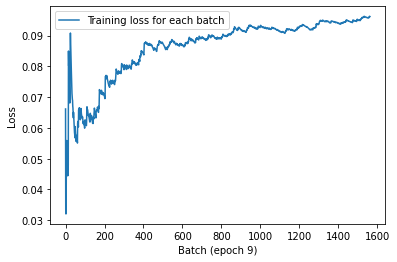

In [39]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=[LossHistory()],
          validation_data=(val_images, val_labels))

##### Monitoring and visualization with TensorBoard
To do good research or develop good models, you need rich, frequent feedback about what’s going on inside your models during your experiments. That’s the point of running experiments: to get information about how well a model performs—as much information as possible. Making progress is an iterative process, a loop—you start with an idea and express it as an experiment, attempting to validate or invalidate your idea. You run this experiment and process the information it generates. This inspires your next idea. The more iterations of this loop you’re able to run, the more refined and powerful your ideas become. Keras helps you go from idea to experiment in the least possible time, and fast GPUs can help you get from experiment to result as quickly as possible. But what about processing the experiment’s results? That’s where TensorBoard comes in (see figure 7.6).

![](./images/7.6.png)

TensorBoard (www.tensorflow.org/tensorboard) is a browser-based application that you can run locally. It’s the best way to monitor everything that goes on inside your model during training. With TensorBoard, you can
- Visually monitor metrics during training
- Visualize your model architecture
- Visualize histograms of activations and gradients
- Explore embeddings in 3D

If you’re monitoring more information than just the model’s final loss, you can develop a clearer vision of what the model does and doesn’t do, and you can make progress more quickly. <br>
The easiest way to use TensorBoard with a Keras model and the **fit()** method is to use the **keras.callbacks.TensorBoard** callback. <br>
In the simplest case, just specify where you want the callback to write logs, and you’re good to go:

In [40]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

tensorboard = keras.callbacks.TensorBoard(log_dir="./logs")

model.fit(train_images, train_labels,
          epochs=10,
          validation_data=(val_images, val_labels),
          callbacks=[tensorboard])

Epoch 1/10
1563/1563 [==============================] - 9s 5ms/step - loss: 0.2950 - accuracy: 0.9128 - val_loss: 0.1534 - val_accuracy: 0.9566
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1664 - accuracy: 0.9524 - val_loss: 0.1316 - val_accuracy: 0.9638
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1388 - accuracy: 0.9626 - val_loss: 0.1149 - val_accuracy: 0.9706
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1279 - accuracy: 0.9671 - val_loss: 0.1137 - val_accuracy: 0.9713
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1207 - accuracy: 0.9706 - val_loss: 0.1105 - val_accuracy: 0.9750
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1125 - accuracy: 0.9717 - val_loss: 0.1144 - val_accuracy: 0.9763
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1077 - accuracy: 0.9747 - val_loss: 0.1165 - val_accuracy:

Once the model starts running, it will write logs at the target location. If you are running your Python script on a local machine, you can then launch the local TensorBoard server using the following command (note that the tensorboard executable should be already available if you have installed TensorFlow via pip; if not, you can install TensorBoard manually via pip install tensorboard):

tensorboard --logdir /full_path_to_your_log_dir

You can then navigate to the URL that the command returns in order to access the TensorBoard interface. <br>
If you are running your script in a Colab notebook, you can run an embedded TensorBoard instance as part of your notebook, using the following commands:

In the TensorBoard interface, you will be able to monitor live graphs of your training and evaluation metrics.

In [45]:
%load_ext tensorboard
%tensorboard --logdir=./logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 16296), started 11:38:39 ago. (Use '!kill 16296' to kill it.)

#### Writing your own training and evaluation loops
The **fit()** workflow strikes a nice balance between ease of use and flexibility. It’s what you will use most of the time. However, it isn’t meant to support everything a deep learning researcher may want to do, even with custom metrics, custom losses, and custom callbacks.

After all, the built-in **fit()** workflow is solely focused on **supervised learning**: a setup where there are known targets (also called labels or annotations) associated with your input data, and where you compute your loss as a function of these targets and the model’s predictions. However, not every form of machine learning falls into this category. There are other setups where no explicit targets are present, such as **generative learning** (which we will discuss in chapter 12), **self-supervised learning** (where targets are obtained from the inputs), and **reinforcement learning** (where learning is driven by occasional “rewards,” much like training a dog). Even if you’re doing regular supervised learning, as a researcher, you may want to add some novel bells and whistles that require low-level flexibility.

Whenever you find yourself in a situation where the built-in **fit()** is not enough, you will need to write your own custom training logic. You already saw simple examples of low-level training loops in chapters 2 and 3. As a reminder, the contents of a typical training loop look like this:
- Run the forward pass (compute the model’s output) inside a gradient tape to obtain a loss value for the current batch of data.
- Retrieve the gradients of the loss with regard to the model’s weights.
- Update the model’s weights so as to lower the loss value on the current batch of data.

These steps are repeated for as many batches as necessary. This is essentially what **fit()** does under the hood. In this section, you will learn to reimplement **fit()** from scratch, which will give you all the knowledge you need to write any training algorithm you may come up with.

Let’s go over the details.

##### Training versus inference
In the low-level training loop examples you’ve seen so far, step 1 (the forward pass) was done via **predictions = model(inputs)**, and step 2 (retrieving the gradients computed by the gradient tape) was done via **gradients = tape.gradient(loss, model.weights)**. In the general case, there are actually two subtleties you need to take into account.

Some Keras layers, such as the **Dropout** layer, have different behaviors during **training** and during **inference** (when you use them to generate predictions). Such layers expose a training Boolean argument in their **call()** method. Calling **dropout(inputs, training=True)** will drop some activation entries, while calling **dropout(inputs, training=False)** does nothing. By extension, Functional and Sequential models also expose this **training** argument in their **call()** methods. Remember to pass **training=True** when you call a Keras model during the forward pass! Our forward pass thus becomes **predictions = model(inputs, training=True)**.

In addition, note that when you retrieve the gradients of the weights of your model, you should not use **tape.gradients(loss, model.weights)**, but rather **tape.gradients(loss, model.trainable_weights)**. Indeed, layers and models own two kinds of weights:
- **Trainable weights**—These are meant to be updated via backpropagation to minimize the loss of the model, such as the kernel and bias of a Dense layer.
- **Non-trainable weights**—These are meant to be updated during the forward pass by the layers that own them. For instance, if you wanted a custom layer to keep a counter of how many batches it has processed so far, that information would be stored in a non-trainable weight, and at each batch, your layer would increment the counter by one.

Among Keras built-in layers, the only layer that features non-trainable weights is the **BatchNormalization** layer, which we will discuss in chapter 9. The **BatchNormalization** layer needs non-trainable weights in order to track information about the mean and standard deviation of the data that passes through it, so as to perform an online approximation of **feature normalization** (a concept you learned about in chapter 6). <br>
Taking into account these two details, a supervised-learning training step ends up looking like this:

In [46]:
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
        gradients = tape.gradients(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(model.trainable_weights, gradients))

##### Low-level usage of metrics
In a low-level training loop, you will probably want to leverage Keras metrics (whether custom ones or the built-in ones). You’ve already learned about the metrics API: simply call **update_state(y_true, y_pred)** for each batch of targets and predictions, and then use **result()** to query the current metric value:

In [47]:
metric = keras.metrics.SparseCategoricalAccuracy()
targets = [0, 1, 2]
predictions = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
metric.update_state(targets, predictions)
current_result = metric.result()
print(f"result: {current_result:.2f}")

result: 1.00


You may also need to track the average of a scalar value, such as the model’s loss. You can do this via the **keras.metrics.Mean** metric:

In [48]:
values = [0, 1, 2, 3, 4]
mean_tracker = keras.metrics.Mean()
for value in values:
    mean_tracker.update_state(value)
print(f"Mean of values: {mean_tracker.result():.2f}")

Mean of values: 2.00


Remember to use **metric.reset_state()** when you want to reset the current results (at the start of a training epoch or at the start of evaluation).

##### A complete training and evaluation loop
Let’s combine the forward pass, backward pass, and metrics tracking into a **fit()** like training step function that takes a batch of data and targets and returns the logs that would get displayed by the **fit()** progress bar.

##### Writing a step-by-step training loop: the training step function

In [49]:
model = get_mnist_model()

loss_fn = keras.losses.SparseCategoricalCrossentropy() # Prepare the loss function.
optimizer = keras.optimizers.RMSprop() # Prepare the optimizer.
metrics = [keras.metrics.SparseCategoricalAccuracy()] # Prepare the list of metrics to monitor.
loss_tracking_metric = keras.metrics.Mean() # Prepare a Mean metric tracker to keep track of the loss average.

def train_step(inputs, targets):
    # Run the forward pass of the model Note that we pass training=True.
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
    # Run the backward pass. Note that we use model.trainable_weights.
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    # Keep track of metrics.
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs[metric.name] = metric.result()

    # Keep track of the loss average.
    loss_tracking_metric.update_state(loss)
    logs["loss"] = loss_tracking_metric.result()
    return logs # Return the current values of the metrics and the loss.

We will need to reset the state of our metrics at the start of each epoch and before running evaluation. Here’s a utility function to do it.

##### Writing a step-by-step training loop: resetting the metrics

In [50]:
def reset_metrics():
    for metric in metrics:
        metric.reset_state()
    loss_tracking_metric.reset_states()

We can now lay out our complete training loop. Note that we use a **tf.data.Dataset** object to turn our NumPy data into an iterator that iterates over the data in batches of size 32.

##### Writing a step-by-step training loop: the loop itself

In [51]:
training_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
training_dataset = training_dataset.batch(32)
epochs = 3
for epoch in range(epochs):
    reset_metrics()
    for inputs_batch, targets_batch in training_dataset:
        logs = train_step(inputs_batch, targets_batch)
    print(f"Results at the end of epoch {epoch}")
    for key, value in logs.items():
        print(f"...{key}: {value:.4f}")

Results at the end of epoch 0
...sparse_categorical_accuracy: 0.9131
...loss: 0.2901
Results at the end of epoch 1
...sparse_categorical_accuracy: 0.9522
...loss: 0.1680
Results at the end of epoch 2
...sparse_categorical_accuracy: 0.9622
...loss: 0.1395


And here’s the evaluation loop: a simple **for** loop that repeatedly calls a **test_step()** function, which processes a single batch of data. The **test_step()** function is just a subset of the logic of **train_step()**. It omits the code that deals with updating the weights of the model—that is to say, everything involving the **GradientTape** and the optimizer.

##### Writing a step-by-step evaluation loop

In [52]:
def test_step(inputs, targets):
    predictions = model(inputs, training=False) # Note that we pass training=False.
    loss = loss_fn(targets, predictions)

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()
    
    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()

for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print("Evaluation results:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

Evaluation results:
...val_sparse_categorical_accuracy: 0.9665
...val_loss: 0.1341


Congrats—you’ve just reimplemented **fit()** and **evaluate()**! Or almost: fit() and evaluate() support many more features, including large-scale distributed computation, which requires a bit more work. It also includes several key performance optimizations. <br>
Let’s take a look at one of these optimizations: TensorFlow function compilation.

##### Make it fast with tf.function
- You may have noticed that your custom loops are running significantly slower than the built-in **fit()** and **evaluate()**, despite implementing essentially the same logic.
- That’s because, by default, TensorFlow code is executed line by line, **eagerly**, much like NumPy code or regular Python code. Eager execution makes it easier to debug your code, but it is far from optimal from a performance standpoint.
- It’s more performant to **compile** your TensorFlow code into a **computation graph** that can be globally optimized in a way that code interpreted line by line cannot. 
- The syntax to do this is very simple: just add a **@tf.function** to any function you want to compile before executing, as shown in the following listing.

##### Adding a @tf.function decorator to our evaluation-step function

In [53]:
@tf.function # This is the only line that is different from the previous code.
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print("Evaluation results:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

Evaluation results:
...val_sparse_categorical_accuracy: 0.9665
...val_loss: 0.1341


On the Colab CPU, we go from taking 1.80 s to run the evaluation loop to only 0.8 s.
<br>Much faster! <br>
Remember, while you are debugging your code, prefer running it eagerly, without any **@tf.function** decorator. It’s easier to track bugs this way. Once your code is working and you want to make it fast, add a **@tf.function** decorator to your training step and your evaluation step—or any other performance-critical function.

##### Leveraging fit() with a custom training loop
In the previous sections, we were writing our own training loop entirely from scratch. Doing so provides you with the most flexibility, but you end up writing a lot of code while simultaneously missing out on many convenient features of **fit()**, such as callbacks or built-in support for distributed training.

What if you need a custom training algorithm, but you still want to leverage the power of the built-in Keras training logic? There’s actually a middle ground between **fit()** and a training loop written from scratch: you can provide a custom training step function and let the framework do the rest. <br>
You can do this by overriding the **train_step()** method of the **Model** class. This is the function that is called by **fit()** for every batch of data. You will then be able to call **fit()** as usual, and it will be running your own learning algorithm under the hood.

Here’s a simple example:
- We create a new class that subclasses **keras.Model**.
- We override the method **train_step(self, data)**. Its contents are nearly identical to what we used in the previous section. It returns a dictionary mapping metric names (including the loss) to their current values.
- We implement a **metrics** property that tracks the model’s **Metric** instances.
  - This enables the model to automatically call **reset_state()** on the model’s metrics at the start of each epoch and at the start of a call to **evaluate()**, so you don’t have to do it by hand.

##### Implementing a custom training step to use with fit()

In [54]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
# This metric object will be used to track the average of per-batch losses during training and evaluation.
loss_tracker = keras.metrics.Mean(name="loss")

class CustomModel(keras.Model):
    # We override the train_step method.
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            # We use self(inputs, training=True) instead of model(inputs, training=True), since our model is the class itself.
            predictions = self(inputs, training=True)
            loss = loss_fn(targets, predictions)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

        # We update the loss tracker metric that tracks the average of the loss.
        loss_tracker.update_state(loss)
        # We return the average loss so far by querying the loss tracker metric.
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        # Any metric you would like to reset across epochs should be listed here.
        return [loss_tracker]

We can now instantiate our custom model, compile it (we only pass the optimizer, since the loss is already defined outside of the model), and train it using **fit()** as usual:

In [55]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop())
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.2948
Epoch 2/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1643
Epoch 3/3
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1373A: 0s - loss: 0


There are a couple of points to note:
- This pattern does not prevent you from building models with the Functional API. You can do this whether you’re building Sequential models, Functional API models, or subclassed models.
- You don’t need to use a @tf.function decorator when you override **train_step**—the framework does it for you.

Now, what about metrics, and what about configuring the loss via **compile()**? After you’ve called **compile()**, you get access to the following:
- **self.compiled_loss**—The loss function you passed to **compile()**.
- **self.compiled_metrics**—A wrapper for the list of metrics you passed, which allows you to call **self.compiled_metrics.update_state()** to update all of your metrics at once.
- **self.metrics**—The actual list of metrics you passed to **compile()**. Note that it also includes a metric that tracks the loss, similar to what we did manually with our **loss_tracking_metric** earlier.

We can thus write

In [56]:
class CustomModel(keras.Model):
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            # Compute the loss via self.compiled_loss.
            loss = self.compiled_loss(targets, predictions)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        # Update the model’s metrics via self.compiled_metrics.
        self.compiled_metrics.update_state(targets, predictions)
        # Return a dict mapping metric names to their current value.
        return {m.name: m.result() for m in self.metrics}

Let’s try it:

In [57]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)

model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.2979 - sparse_categorical_accuracy: 0.9115A: 
Epoch 2/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1673 - sparse_categorical_accuracy: 0.9531
Epoch 3/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1426 - sparse_categorical_accuracy: 0.9614


That was a lot of information, but you now know enough to use Keras to do almost anything.

#### Summary
- Keras offers a spectrum of different workflows, based on the principle of *progressive disclosure of complexity*. They all smoothly inter-operate together.
- You can build models via the Sequential class, via the Functional API, or by subclassing the Model class. Most of the time, you’ll be using the Functional API.
- The simplest way to train and evaluate a model is via the default **fit()** and **evaluate()** methods.
- Keras callbacks provide a simple way to monitor models during your call to **fit()** and automatically take action based on the state of the model.
- You can also fully take control of what **fit()** does by overriding the **train_step()** method.
- Beyond **fit()**, you can also write your own training loops entirely from scratch. This is useful for researchers implementing brand-new training algorithms.